# Training on data from the Osiris-Rex mission

In this notebook we perform the training of a GeodesyNet using the observed trajectories of detached pebbles.

During the time of observation, Bennu ejected multiple small rock pebbles. Many of these stayed in orbit around Bennu for several days before either falling back to Bennu's surface or escaping its gravitational influence. These trajectories yield additional samples of the gravity field. However, due to their small size, they have a high surface-to-mass ratio and radiation effects play a large role, adding substantial unmodelled effects to their trajectories and thus to the value of the purely gravitational acceleration that can be computed from them.

NOTE: With respect to a normal training (see Starter Notebook) the difference is only on the dataset used. In the Starter Notebook we use synthetically generated data provided via a sampler. Here we use data precomputed from the real observed pebble trajectories. Here we do not make use of any prior knowledge on Bennu shape model.

We suggest to run this notebook in the same conda environment as the one described in the Starter Notebook.

In [1]:
# core stuff
import gravann
import numpy as np
import pickle as pk
import os
from collections import deque

# pytorch
from torch import nn
import torch

# plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib notebook

# Ensure that changes in imported module (gravann most importantly) are autoreloaded
%load_ext autoreload
%autoreload 2

# If possible enable CUDA
gravann.enableCUDA()
gravann.fixRandomSeeds()
device = os.environ["TORCH_DEVICE"]
print("Will use device ",device) 


Available devices  1
__pyTorch VERSION: 1.6.0
__CUDNN VERSION: 7605
__Number CUDA Devices: 1
Active CUDA Device: GPU 0
Setting default tensor type to Float32
Will use device  cuda:0


# Loading and visualizing the ground truth asteroid (a point cloud)

In [2]:
# We load a homogeneous mass Bennu mascon model. IMPORTANT: this will not be used for training.
# Here we use a mascon model that has not been modified in its center of mass nor principal axes.
# It is dervied directly from the shape model available here: https://www.asteroidmission.org/updated-bennu-shape-model-3d-files/
# and is considered compatible with the reference frame of the pebble trajectories.
with open("mascons/Bennu_unrotated.pk", "rb") as file:
    mascon_points, mascon_masses, mascon_name = pk.load(file)
    
# We also load the asteroid mesh as to be able to check what points are inside
with open("3dmeshes/Bennu_lp_unrotated.pk", "rb") as file:
    mesh_points, mesh_triangles = pk.load(file)
    
mascon_points = np.array(mascon_points)
mascon_masses = np.array(mascon_masses)

mesh_points = np.array(mesh_points)
mesh_triangles = np.array(mesh_triangles)

# Print some information on the loaded ground truth 
# (non-dimensional units assumed. All mascon coordinates are thus in -1,1 and the mass is 1)
print("Name: ", mascon_name)
print("Number of mascons: ", len(mascon_points))
print("Total mass: ", sum(mascon_masses))

Name:  Bennu
Number of mascons:  37964
Total mass:  1.0000000000000053


<IPython.core.display.Javascript object>


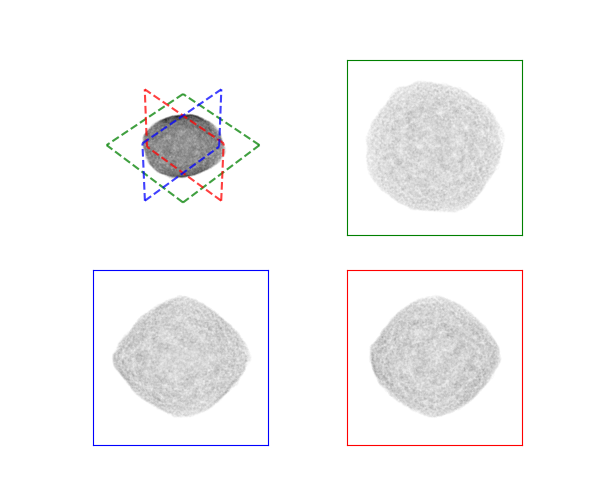

In [3]:
gravann.plot_mascon(mascon_points, mascon_masses)

## Loading the pebbles trajectories data, 
The data we use here was created using a different notebook where we exctract and process the info from the pebbles SPICE kernels

In [4]:
# We have stored, in the pickled file, the pebble position, the gravitational acceleration
# derived from it, the epoch and the corresponding pebble id
with open("osirisrex/unfiltered_pebbles.pk", "rb") as file:
    epochs_raw, pebble_id_raw, data_points_raw, data_labels_raw = pk.load(file)

In [5]:
# Due to numerics some pebbles are actually inside our low precisiion 3d mesh model of
# Bennu. We filter them out to be on the safe side
outside_mask = gravann.is_outside(data_points_raw, mesh_points, mesh_triangles)
data_points_p = np.array(data_points_raw[outside_mask])
data_labels_p = np.array(data_labels_raw[outside_mask])
pebble_id = np.array(pebble_id_raw)[outside_mask]
epochs = np.array(epochs_raw)[outside_mask]

In [6]:
# We store here the unique ids of the pebbles
ids = np.unique(pebble_id)

# We print a summary of the dataset
print("Number of data points (raw): ", len(data_points_raw))
print("Number of data points (cleaned): ", len(data_points_p))
print("Number of invalid data points (inside the asteroid): ", len(data_points_raw)-len(data_points_p))
print("Number of distinct pebbles: ", len(ids))

Number of data points (raw):  344969
Number of data points (cleaned):  342400
Number of invalid data points (inside the asteroid):  2569
Number of distinct pebbles:  313


## Looking at the pebbles trajectories data


First we plot the trajectory for one of the pebbles, change the id to see more

<IPython.core.display.Javascript object>


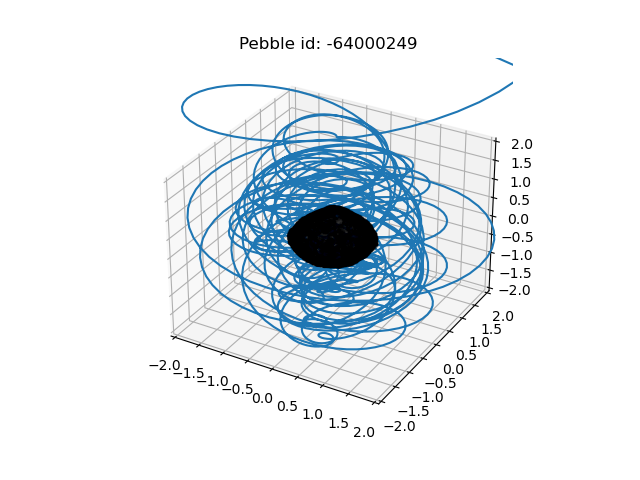

In [7]:
# Extract one only pebble trajectory from the data
id_p = ids[124]
mask = pebble_id==id_p
one_pebble = data_points_p[mask]

# Define the coordinates to be plotted for the pebble
xp = one_pebble[:,0]
yp = one_pebble[:,1]
zp = one_pebble[:,2]

# And the underlying mascon model of Bennu (for reference)
xm = mascon_points[:, 0]
ym = mascon_points[:, 1]
zm = mascon_points[:, 2]

# Set up Figure and 3D Axes 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
D=2
ax.set_xlim([-D, D])
ax.set_ylim([-D, D])
ax.set_zlim([-D, D])

# Plot the mascon
ax.scatter(xm, ym, zm, alpha=0.05, s=1, c='k')
# Plot the pebble
ax.plot(xp,yp,zp)

plt.title("Pebble id: {}".format(id_p));

... then we have a look at the statistics over the whole dataset

In [8]:
# This is the distance of each datapoint to the origin
distances = np.linalg.norm(data_points_p, axis=1)
# This is the label as computed by a homogenous mascon model
data_labels_p_from_mascon = gravann.ACC_L(torch.tensor(data_points_p), torch.tensor(mascon_points), torch.tensor(mascon_masses)).cpu().numpy()
# This is de difference between the magnitudes of the acceleration as computed by a homogenous mascon model 
# and the labels (i.e. the acceleration computed from the pebble trajectories)
diff = np.abs(np.linalg.norm(data_labels_p_from_mascon, axis=1) - np.linalg.norm(data_labels_p, axis=1))

A first, interesting, plot shows the realtive error between the accelerations as computed from the homogenous mascon model and from the pebbles trajectories.

We see that **close to asteroid surface high values can be the effect of inhomogenuities** on the asteroid internal structure. These are precious to understand Bennu internal mass distribution.

**Far away from the asteroid, (r>1) large values can only be the effect of modelling errors** and noise in the trajectory inversion and the mascon model discretization. They likely bear little information on Bennu internal mass distribution.

<IPython.core.display.Javascript object>


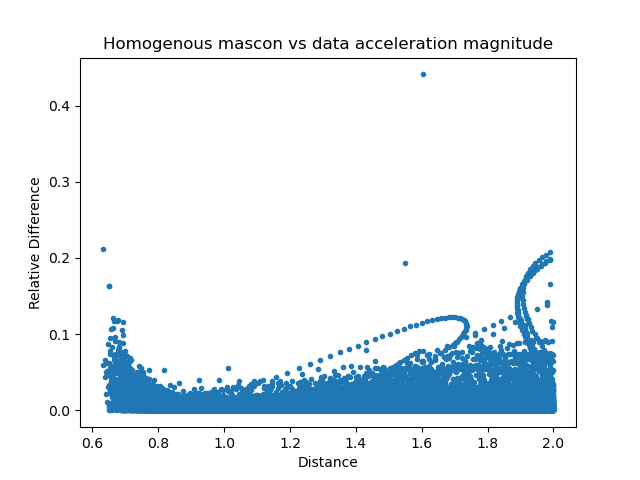

Text(0, 0.5, 'Relative Difference')

In [9]:
# Plotting the difference in magnitude of the accelerations homogenous mascon vs labels
plt.figure()
mask = distances < 2
plt.plot(distances[mask], (diff/np.linalg.norm(data_labels_p, axis=1))[mask], '.')
plt.title("Homogenous mascon vs data acceleration magnitude")
plt.xlabel("Distance")
plt.ylabel("Relative Difference")

A last plot shows the histogram of the distances of all points in the database. 

<IPython.core.display.Javascript object>


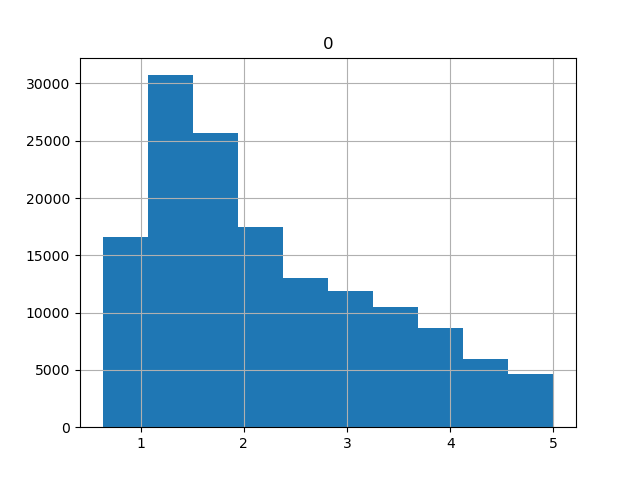

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

In [10]:
import pandas as pd
dist = pd.DataFrame(distances[distances<5])
dist.hist()

# Representing an asteroid via a neural network


## 1 - Defining the network architecture
The networks inputs are the cartesian coordinates of a point in the unit cube, encoded via some transformation

In [21]:
# Encoding: direct encoding (i.e. feeding the network directly with the Cartesian coordinates in the unit hypercube)
# was found to work well in most cases. But more options are implemented in the module.
encoding = gravann.direct_encoding()

# The model is here a SIREN network (FFNN with sin non linearities and a final absolute value to predict the density)
model = gravann.init_network(encoding, n_neurons=100, model_type="siren", activation = gravann.AbsLayer())

# When a new network is created we init empty training logs
loss_log = []
weighted_average_log = []
running_loss_log = []
n_inferences = []
# .. and we init a loss trend indicators
weighted_average = deque([], maxlen=20)

In [22]:
## IF YOU WANT TO LOAD AN ALREADY TRAINED NETWORK UNCOMMENT HERE.
## It is important that the network architecture is compatible, otherwise this will fail

#model.load_state_dict(torch.load("model.mdl"))

# Once a model is loaded the learned constant c (named kappa in the paper) is unknown 
# and must be relearned (ideally it should also be saved at the end of the training as it is a learned parameter)
#c = gravann.compute_c_for_model(model, encoding, mascon_points, mascon_masses, use_acc = True)

## 2 - Visualizing the initial neural density field¶
The network output is the density in the unit cube. It is, essentially, a three dimensional function. (Does not work with differetial training!)

Sampling points...: 10031it [00:10, 928.01it/s]                                                                        


<IPython.core.display.Javascript object>


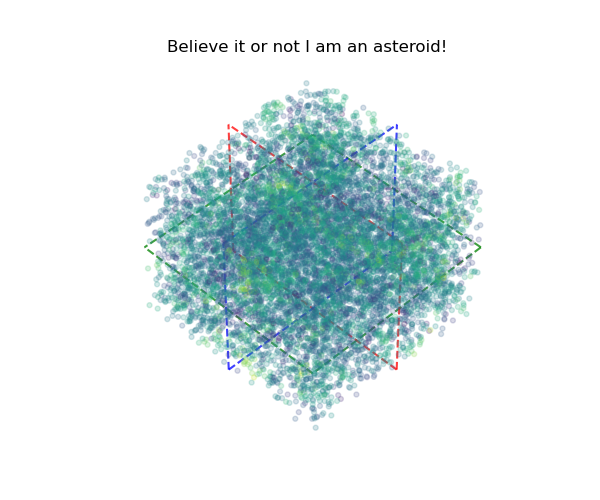

Text(0.5, 0.92, 'Believe it or not I am an asteroid!')

In [23]:
# The rejection plot will visualize the neural density field as a probability distribution function. 
# Colors represent the density magnitude (white being zero). 
# At the beginning, the whole hypercube is filled with some non vanishing density.
gravann.plot_model_rejection(model, encoding, views_2d=False, N=10000, progressbar=True, c=1)
plt.title("Believe it or not I am an asteroid!")

# Training of a geodesyNet

In [25]:
# EXPERIMENTAL SETUP ------------------------------------------------------------------------------------
# Number of points to be used to evaluate numerically the triple integral
# defining the acceleration. 
# Use <=30000 to for a quick training ... 300000 was used to produce most of the paper results
n_quadrature = 300000

# Dimension of the batch size, i.e. number of points
# where the ground truth is compared to the predicted acceleration
# at each training epoch.
# Use 100 for a quick training. 1000  was used to produce most of the paper results
batch_size = 500

# Loss. The normalized L1 loss (kMAE in the paper) was
# found to be one of the best performing choices.
# More are implemented in the module
loss_fn = gravann.normalized_L1_loss

# The numerical Integration method. 
# Trapezoidal integration is here set over a dataset containing acceleration values,
# (it is possible to also train on values of the gravity potential, results are similar)
mc_method = gravann.ACC_trap

# NOTE: The sampling method is not needed as we work here with real data, not synthetic.
# Instead we here filter the dataset to only keep points with some properties
mask = distances < 3
target_points_all = torch.tensor(data_points_p[mask])
labels_all = torch.tensor(data_labels_p[mask])

# Here we set the optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.8, patience = 200, min_lr = 1e-6,verbose=True)

# And init the best results
best_loss = np.inf
best_model_state_dict = model.state_dict()

In [26]:
# This cell can be stopped and started again without loosing memory of the training nor its indicators
torch.cuda.empty_cache()
plt.close('all')
# The main training loop
for i in range(1000):
    # Each ten epochs we resample the target points at random from the dataset
    if (i % 10 == 0):
        idxs = np.random.choice(np.arange(len(target_points_all)), batch_size, replace=False)
        target_points = target_points_all[idxs]
        labels = labels_all[idxs]
    
    # We compute the values predicted by the neural density field
    predicted = mc_method(target_points, model, encoding, N=n_quadrature)
    
    # We learn the scaling constant (k in the paper)
    c = torch.sum(predicted*labels)/torch.sum(predicted*predicted)
    
    # We compute the loss (note that the contrastive loss needs a different shape for the labels)
    if loss_fn == gravann.contrastive_loss:
       loss = loss_fn(predicted, labels)
    else:
       loss = loss_fn(predicted.view(-1), labels.view(-1))
    
    # We store the model if it has the lowest fitness 
    # (this is to avoid losing good results during a run that goes wild)
    if loss < best_loss:
        best_model_state_dict = model.state_dict()
        best_loss = loss
        print('New Best: ', loss.item())
    
    # Update the loss trend indicators
    weighted_average.append(loss.item())
    
    # Update the logs
    weighted_average_log.append(np.mean(weighted_average))
    loss_log.append(loss.item())
    n_inferences.append((n_quadrature*batch_size) // 1000)
    
    # Print every i iterations
    if i % 25 == 0:
        wa_out = np.mean(weighted_average)
        print(f"It={i}\t loss={loss.item():.3e}\t  weighted_average={wa_out:.3e}\t  c={c:.3e}")
        
    # Zeroes the gradient (necessary because of things)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()
    
    # Perform a step in LR scheduler to update LR
    scheduler.step(loss.item())

New Best:  0.10454726319234801
It=0	 loss=1.045e-01	  weighted_average=1.045e-01	  c=3.117e+00
New Best:  0.10220365510159626
New Best:  0.09740159399882785
New Best:  0.07774325481259547
New Best:  0.0726282641402323
New Best:  0.054514294498818075
New Best:  0.04236986510379046
New Best:  0.03456669216095619
New Best:  0.026858411165227483
New Best:  0.024626475484534144
New Best:  0.01618206611859262
It=25	 loss=1.776e-02	  weighted_average=4.743e-02	  c=2.425e+00
New Best:  0.013918770182705898
New Best:  0.011819306106856293
New Best:  0.01154346855870374
New Best:  0.010926819824507793
New Best:  0.00968518240205536
New Best:  0.008857120437449729
New Best:  0.007973320563000786
New Best:  0.007829615724698766
New Best:  0.007298991999918954
New Best:  0.007072877183730016
New Best:  0.0067225243749694475
New Best:  0.006017823089645635
New Best:  0.005734539080480772
New Best:  0.005607327359904128
New Best:  0.005103994058807116
New Best:  0.004775895514277771
New Best:  0.0047

In [27]:
# Here we restore the learned parameters of the best model of the run
for layer in model.state_dict():
    model.state_dict()[layer] = best_model_state_dict[layer]

## Interpretation of the neural density field learned

<IPython.core.display.Javascript object>


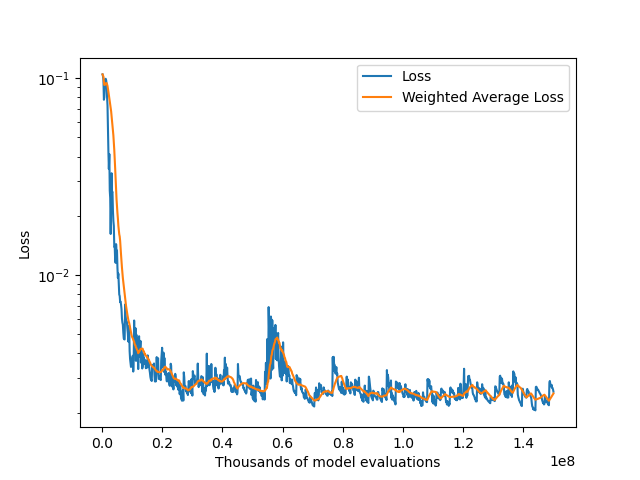

In [28]:
# First lets have a look at the training loss history
plt.figure()
abscissa = np.cumsum(n_inferences)
plt.semilogy(abscissa, loss_log)
plt.semilogy(abscissa, weighted_average_log)
plt.xlabel("Thousands of model evaluations")
plt.ylabel("Loss")
plt.legend(["Loss","Weighted Average Loss"])

Sampling points...: 1855it [00:01, 1656.08it/s]                                                                        


<IPython.core.display.Javascript object>


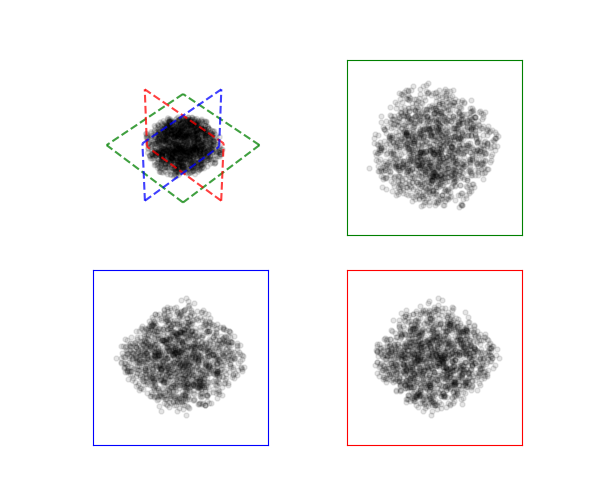

In [29]:
# Lets have a look at the neural density field.
# First with a rejection plot
gravann.plot_model_rejection(model, encoding, views_2d=True, bw=True, N=1500, alpha=0.1, s=50, c=c, crop_p=0.1, progressbar=True);

Sampling points...: 2611it [00:01, 1826.75it/s]                                                                        


<IPython.core.display.Javascript object>


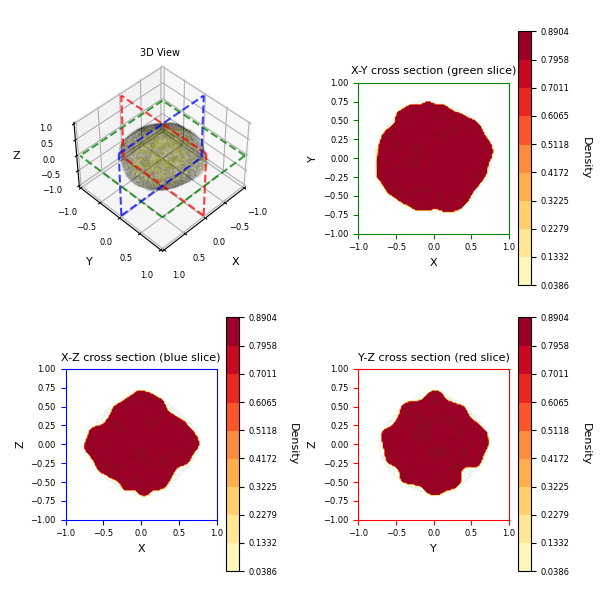

<Axes3DSubplot:title={'center':'3D View'}, xlabel='X', ylabel='Y'>

In [30]:
# Then overlaying a heatmap to the mascons 
gravann.plot_model_vs_mascon_contours(model, encoding, torch.tensor(mascon_points), torch.tensor(mascon_masses),c=c, progressbar = True, N=2500, heatmap=True)

#### Saving the model

In [20]:
# Uncomment to save to models
#torch.save(model.state_dict(), "models/siren_acc_bennu.mdl")